In [4]:
! pip install requests

In [21]:
import requests
import json
import time
import random
import os
from datetime import datetime

MAX_PAGES_TO_SCRAPE = 100  
RESULTS_PER_PAGE = 100     

LISTING_API_BASE = "https://api.bdjobs.com/Jobs/api/JobSearch/GetJobSearch?Icat=&industry=&category=&org=&jobNature=&Fcat=&location=&Qot=&jobType=&jobLevel=&postedWithin=&deadline=&keyword=&pg={}&qAge=&Salary=&experience=&gender=&MExp=&genderB=&MPostings=&MCat=&version=&rpp={}&Newspaper=&armyp=&QDisablePerson=&pwd=&workplace=&facilitiesForPWD=&SaveFilterList=&UserFilterName=&HUserFilterName=&earlyJobAccess=&isPro=0&ToggleJobs=true&isFresher=false"
DETAILS_API_URL = "https://gateway.bdjobs.com/jobapply/api/JobSubsystem/Job-Details"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Origin": "https://bdjobs.com",
    "Referer": "https://bdjobs.com/"
}

FILENAME = "Realtime_Jobs_Data.json"

def get_delay():
    return random.uniform(2.0, 4.0)

def fetch_job_details(job_id):
    params = {"jobId": job_id, "ln": "1", "IsCorporate": "false"}
    try:
        time.sleep(get_delay()) 
        response = requests.get(DETAILS_API_URL, params=params, headers=HEADERS, timeout=15)
        
        if response.status_code == 200:
            resp_json = response.json()
            if 'data' in resp_json:
                inner_data = resp_json['data']
                if isinstance(inner_data, list):
                    return inner_data[0] if len(inner_data) > 0 else None
                elif isinstance(inner_data, dict):
                    return inner_data
            return None
        elif response.status_code == 429:
            print("Too fast! Server asked to slow down. Pausing for 60s...")
            time.sleep(60)
            
    except Exception as e:
        print(f"Error fetching {job_id}: {e}")
    return None

def run_full_scraper():
    all_jobs_data = []
    existing_ids = set()

    # LOAD EXISTING DATABASE
    if os.path.exists(FILENAME):
        try:
            print(f"Loading existing database: {FILENAME}")
            with open(FILENAME, 'r', encoding='utf-8') as f:
                all_jobs_data = json.load(f)
                
                # Memorize IDs (PascalCase & camelCase support)
                for job in all_jobs_data:
                    jid = job.get('JobId') or job.get('Jobid') or job.get('jobId')
                    if jid:
                        existing_ids.add(str(jid))
                        
            print(f"Loaded & Memorized {len(existing_ids)} existing Job IDs.")
            
        except Exception as e:
            print(f"Error loading file: {e}. Starting fresh.")
            all_jobs_data = []
            existing_ids = set()
    else:
        print("Starting fresh (No database found).")

    page = 1
    total_new_jobs = 0
    
    print(f"STARTING FULL SCRAPE at {datetime.now().strftime('%H:%M:%S')}")
    print(f"Target: Up to {MAX_PAGES_TO_SCRAPE} Pages.")
    print("------------------------------------------------")
    
    while page <= MAX_PAGES_TO_SCRAPE:
        list_url = LISTING_API_BASE.format(page, RESULTS_PER_PAGE)
        print(f"\n--- Processing Page {page} ---")
        
        try:
            resp = requests.get(list_url, headers=HEADERS, timeout=20)
            
            if resp.status_code != 200:
                print(f"Listing API Error: {resp.status_code}")
                break

            data = resp.json().get('data', [])
            
            if not data:
                print("No more jobs found. Reached end of list.")
                break
            
            current_page_ids = []
            for job in data:
                jid = job.get('Jobid') or job.get('jobId')
                if jid:
                    current_page_ids.append(str(jid))
            
            print(f"Found {len(current_page_ids)} jobs on this page.")
            
            #COMPARISON & FETCH 
            skipped_count = 0
            new_on_page = 0
            
            for i, job_id in enumerate(current_page_ids):
                
                # SKIP Check
                if job_id in existing_ids:
                    skipped_count += 1
                    continue
                
                # FETCH New Job
                print(f"   [NEW] ID: {job_id}. Fetching details...")
                details = fetch_job_details(job_id)
                
                if details:
                    all_jobs_data.append(details)
                    existing_ids.add(job_id)
                    new_on_page += 1
                    total_new_jobs += 1
                    
                    title = details.get('JobTitle') or details.get('jobTitle') or "Unknown"
                    print(f"   Added: {title[:40]}...")
                    
                    # Safety Save 
                    if total_new_jobs % 10 == 0:
                        with open(FILENAME, "w", encoding="utf-8") as f:
                            json.dump(all_jobs_data, f, ensure_ascii=False, indent=4)
                        print("   (Auto-saved progress)")

            print(f"   >> Summary: Skipped {skipped_count} (Old) | Added {new_on_page} (New)")
            
            if len(data) < RESULTS_PER_PAGE:
                print("This was the last page.")
                break

            page += 1
            
            if new_on_page == 0:
                print("   (All skipped, moving fast...)")
                time.sleep(1) 
            else:
                print("   (Taking a short break...)")
                time.sleep(3) 

        except Exception as e:
            print(f"Critical Error on Page {page}: {e}")
            print("Pausing for 10 seconds before retry...")
            time.sleep(10)
    
    # Final Save
    print("Saving Final Database...")
    with open(FILENAME, "w", encoding="utf-8") as f:
        json.dump(all_jobs_data, f, ensure_ascii=False, indent=4)
        
    print(f"FULL JOB COMPLETE!")
    print(f"Total Jobs in Database: {len(all_jobs_data)}")
    print(f"New Jobs Added Today: {total_new_jobs}")

if __name__ == "__main__":
    run_full_scraper()

Loading existing database: Realtime_Jobs_Data.json


KeyboardInterrupt: 

**Libraries & Setup**

In [37]:
import pandas as pd
import numpy as np
import json
import re
from bs4 import BeautifulSoup
import warnings

# কনফিগারেশন
warnings.filterwarnings('ignore')

# --- DISPLAY SETTINGS FIX ---
# এই সেটিংগুলো রান করলে টেবিল আর ভাঙবে না
pd.set_option('display.max_colwidth', 50)  # বড় টেক্সট ছোট করে '...' দেখাবে
pd.set_option('display.max_columns', None) # কিন্তু সব কলাম দেখাবে
pd.set_option('display.width', 1000)       # উইন্ডোর সাইজ ঠিক রাখবে

print("✅ Libraries Imported & Display Settings Fixed!")

✅ Libraries Imported & Display Settings Fixed!


**Load Data & Inspect**

In [52]:
# ডেটা লোড
try:
    df = pd.read_json('Realtime_Jobs_Data.json')
    
    print(f"Total Rows: {df.shape[0]}, Total Columns: {df.shape[1]}")

    # সব কলামের নাম প্রিন্ট করা
    print("\nExisting Columns:")
    print(df.columns.tolist())

    # প্রথম ৩টি রো দেখা
    print("\nData Preview:")
    display(df.head(3)) # জুপিটারে print এর চেয়ে display() ভালো দেখায়

except ValueError:
    print("❌ Error: 'Realtime_Jobs_Data.json' ফাইলটি পাওয়া যাচ্ছে না।")

Total Rows: 13597, Total Columns: 70

Existing Columns:
['test', 'JobId', 'JobFound', 'error', 'CompnayName', 'JobTitle', 'PostedOn', 'Deadline', 'DeadlineDB', 'JobVacancies', 'JobDescription', 'JobNature', 'JobWorkPlace', 'EducationRequirements', 'SkillsRequired', 'SuggestedSkills', 'Publications', 'Age', 'experience', 'Gender', 'AdditionJobRequirements', 'JobLocation', 'OnlineApply', 'CompanyBusiness', 'CompanyAddress', 'CompanyHideAddress', 'CompanyWeb', 'JobAppliedEmail', 'JobSource', 'JobOtherBenifits', 'RecruitmentProcessingInformation', 'RecruitingCompanysProfile', 'JobSalaryRange', 'JobSalaryRangeText', 'JobSalaryMinSalary', 'JobSalaryMaxSalary', 'ShowSalary', 'overseasnote', 'JobAdType', 'JobLOgoName', 'JobKeyPoints', 'ApplyInstruction', 'ApplyEmail', 'HardCopy', 'WalkInInterview', 'ApplyURL', 'Photograph', 'PhotographMsg', 'JObIMage', 'upcoming', 'upcomingln', 'CompanyOtherJ0bs', 'CompanyID', 'CompanyNameENG', 'AssessmentRequired', 'Context', 'RLNO', 'PreferVideoResume', 'Att

,test,JobId,JobFound,error,CompnayName,JobTitle,PostedOn,Deadline,DeadlineDB,JobVacancies,JobDescription,JobNature,JobWorkPlace,EducationRequirements,SkillsRequired,SuggestedSkills,Publications,Age,experience,Gender,AdditionJobRequirements,JobLocation,OnlineApply,CompanyBusiness,CompanyAddress,CompanyHideAddress,CompanyWeb,JobAppliedEmail,JobSource,JobOtherBenifits,RecruitmentProcessingInformation,RecruitingCompanysProfile,JobSalaryRange,JobSalaryRangeText,JobSalaryMinSalary,JobSalaryMaxSalary,ShowSalary,overseasnote,JobAdType,JobLOgoName,JobKeyPoints,ApplyInstruction,ApplyEmail,HardCopy,WalkInInterview,ApplyURL,Photograph,PhotographMsg,JObIMage,upcoming,upcomingln,CompanyOtherJ0bs,CompanyID,CompanyNameENG,AssessmentRequired,Context,RLNO,PreferVideoResume,AttachedResume,bottomAlertMsg,ProUser,ApplicantMatchingScore,CategoryID,C2C,MobileNo,CONFIDENTIAL,NewspaperJob,Closed,ApplyRedirectUrl,AccessibilityAware
0,1,1436370,True,0,RK Supply Ltd.,Data Analyst / Accounts Officer,"Dec 6, 2025","Dec 31, 2025",12/31/2025 00:00:00,6,"<p><strong><span style=""color:rgb(51, 51, 51);...",Full Time,Work at office,<ul><ul><li>Bachelor of Business Administratio...,"Accounting,Accounting Data Entry,Canva Pro,Dat...","Accounting Data Entry,Accounting Software,Acco...",0,20 to 35 years,<ul><li>At least 1 year</li><li>The applicants...,"M,F",<ul><li>Age 20 to 35 years</li></ul>,Dhaka (Banani),True,,,True,,,,,,,Tk. 20000 - 35000 (Monthly),,20000,35000,1,,1,,"<p><strong><span style=""color:rgb(51, 51, 51)""...",Selected candidates for this role will be trai...,,,,,-,-,,,,0,109093,RK Supply Ltd.,No,,,0,0,বিডিজবস-এ প্রকাশিত যেকোনো চাকরি সংক্রান্ত তথ্য...,0,0,8,0,,,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?c7`6...,[]
1,1,1437042,True,0,Pridesys IT Limited,Processor/Senior Processor,"Dec 6, 2025","Jan 5, 2026",01/05/2026 00:00:00,2,<ul><li>Review property preservation work orde...,Full Time,Work at office,<ul><ul><li>Bachelor/Honors</li></ul></ul>,"Flexibility and Adaptability,Google Sheets,MS ...","Client Service,Property Management,Property Pr...",0,20 to 35 years,<ul><li>At most 2 years</li><li>Freshers are a...,M,<ul><li>Age 20 to 35 years</li><li>Only Male</...,Dhaka (Kawran Bazar),True,Pridesys IT Ltd. own developed ERP product for...,"Level-11, Vision 2021 Tower-1, Software Techno...",False,,,,<ul><li>Salary Review: Yearly</li><li>Festival...,,,Negotiable,,0,0,1,,1,https://corporate.bdjobs.com/logos/38072_0.png,,,,,,,-,-,,,,0,38072,Pridesys IT Limited,No,,,0,0,বিডিজবস-এ প্রকাশিত যেকোনো চাকরি সংক্রান্ত তথ্য...,0,0,8,0,,,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?a4]7...,[]
2,1,1437039,True,0,Aalok Healthcare & Hospital,Assistant Manager (Customer Care / Admin),"Dec 6, 2025","Dec 26, 2025",12/26/2025 00:00:00,4,<h3>Shift Management and Operational Leadershi...,Full Time,Work at office,<ul><ul><li>Masters</li></ul></ul>,"Computer Literacy,Customer Service,Health/ Med...","Administration,Complaint Management,Hospital B...",0,Na,<ul><li>3 to 5 years</li><li>The applicants sh...,M,<ul><li>Only Male</li></ul> <ul><li><p>3 to 5 ...,Dhaka (Mirpur),True,,"Corporate Office: House# 3, Road # 4, Block # ...",False,https://www.aalokhealthcare.com/,,,<ul><li>Provident fund</li><li>Salary Review: ...,,,--,,0,0,0,,1,https://corporate.bdjobs.com/logos/92299_3.png,,<p>Read before Apply and email us mention as E...,Send your CV to the given email hr.aalok@gmail...,,,,-,-,,,,4,92299,Aalok Healthcare & Hospital,No,,,1,0,বিডিজবস-এ প্রকাশিত যেকোনো চাকরি সংক্রান্ত তথ্য...,0,0,11,0,,,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?3_7a...,[{'Name': 'Do you have Disability Inclusion Po...


**Standardize Column Names**

In [39]:
# সব কলামের নাম ম্যাপ করা
rename_map = {
    'JobId': 'job_id', 'CompnayName': 'company_name', 'CompanyID': 'company_id', 'CategoryID': 'category_id',
    'JobTitle': 'job_title', 'JobDescription': 'job_description', 'JobNature': 'job_type',
    'JobWorkPlace': 'work_place', 'PostedOn': 'posted_on', 'Deadline': 'deadline',
    'JobVacancies': 'vacancies', 'JobLocation': 'raw_location', 'EducationRequirements': 'raw_education',
    'SkillsRequired': 'skills', 'SuggestedSkills': 'suggested_skills', 'experience': 'experience',
    'Age': 'age', 'Gender': 'gender', 'JobSalaryMinSalary': 'min_salary', 'JobSalaryMaxSalary': 'max_salary',
    'JobSalaryRange': 'salary_range', 'ApplyURL': 'apply_url', 'ApplyEmail': 'apply_email',
    'ApplyInstruction': 'apply_instruction', 'CompanyWeb': 'company_web', 'CompanyAddress': 'company_address',
    'CompanyBusiness': 'company_business', 'JobOtherBenifits': 'job_benefits', 'JobSource': 'job_source',
    'OnlineApply': 'online_apply'
}

# নাম পরিবর্তন করা (কিন্তু সব কলাম রাখা)
df = df.rename(columns=rename_map)

# ID গুলোকে স্ট্রিং বানানো (সায়েন্টিফিক নোটেশন এড়ানোর জন্য)
for col in ['job_id', 'company_id', 'category_id']:
    if col in df.columns:
        df[col] = df[col].astype(str)

print("Column names standardized!")

Column names standardized!


**Cleaning HTML Content**

In [40]:
def clean_html_text(text):
    if not isinstance(text, str): return text
    if pd.isna(text) or text == "": return None
    try:
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text(separator=" ")
    except: pass
    return re.sub(r'\s+', ' ', text).strip()

# যেসব কলামে HTML ট্যাগ থাকতে পারে
text_cols = ['job_description', 'job_benefits', 'apply_instruction', 'raw_education', 'skills', 'suggested_skills', 'company_business']

print("Cleaning HTML tags...")

for col in text_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_html_text)

# গারবেজ ভ্যালু নাল (NaN) করে দেওয়া
missing_indicators = ["--", "N/A", "n/a", "Not Applicable", "[]", "", " ", "0000-00-00", "Any"]
df.replace(missing_indicators, np.nan, inplace=True)

print("HTML Cleaning Done!")

Cleaning HTML tags...
HTML Cleaning Done!


**Feature Extraction (Age, Loc, Edu)**

In [41]:
# --- Helper Functions ---
def extract_range(text):
    """Age বা Experience থেকে min/max বের করে"""
    if pd.isna(text): return None, None
    numbers = re.findall(r'\d+', str(text))
    if not numbers: return None, None
    nums = [int(n) for n in numbers]
    if len(nums) >= 2: return nums[0], nums[1]
    elif len(nums) == 1: return nums[0], None
    return None, None

def extract_loc_edu(row):
    """Location & Education Logic"""
    raw_loc = str(row.get('raw_location', '')).strip()
    raw_edu = str(row.get('raw_education', '')).lower().strip()
    
    # Location
    dist, fine = raw_loc, "none"
    if "anywhere in bangladesh" in raw_loc.lower():
        dist = "Anywhere in Bangladesh"
    elif "(" in raw_loc:
        parts = re.findall(r"([^(]+)\s*\(([^)]+)\)", raw_loc)
        if parts: dist, fine = parts[0][0].strip(), parts[0][1].strip()

    # Education
    level, subject = "Any", "Any"
    if any(x in raw_edu for x in ['cse', 'computer science', 'it', 'software']):
        level, subject = "Bachelor", "Computer Science"
    elif any(x in raw_edu for x in ['bba', 'mba', 'business']):
        level, subject = "Bachelor", "Business Administration"
    elif 'diploma' in raw_edu:
        level, subject = "Diploma", "Engineering"
    
    return pd.Series([dist, fine, level, subject])

# --- Applying Logic ---
print("Generating new columns...")

# 1. Location & Education
df[['district', 'fine_grained_location', 'education_level', 'education_subject']] = df.apply(extract_loc_edu, axis=1)

# 2. Age
if 'age' in df.columns:
    age_data = df['age'].apply(extract_range)
    df['min_age'] = age_data.apply(lambda x: x[0])
    df['max_age'] = age_data.apply(lambda x: x[1])

# 3. Experience
if 'experience' in df.columns:
    exp_data = df['experience'].apply(extract_range)
    df['min_experience'] = exp_data.apply(lambda x: x[0])
    df['max_experience'] = exp_data.apply(lambda x: x[1])

# 4. Salary & Vacancies Fix
if 'vacancies' in df.columns:
    df['vacancies'] = pd.to_numeric(df['vacancies'], errors='coerce')
for col in ['min_salary', 'max_salary']:
    if col in df.columns: df[col] = df[col].replace(0, np.nan)

print("New Features Created: min_age, district, education_level, etc.")

Generating new columns...
New Features Created: min_age, district, education_level, etc.


**Category analysis**

In [42]:
import pandas as pd

# ১. এনালাইসিসের জন্য আমরা সাময়িকভাবে সব টেক্সট দেখতে চাই
pd.set_option('display.max_rows', None)

print("🔍 Full Category Analysis (Sorted by ID):")
print("="*60)

# ২. এনালাইসিস: কোন আইডিতে কোন জবগুলো বেশি
# (Error Handling সহ, যাতে ডেটা টাইপ নিয়ে সমস্যা না হয়)
try:
    cat_analysis = df.groupby('category_id')['job_title'].apply(
        lambda x: x.value_counts().head(3).index.tolist()
    )
    
    # ইনডেক্স ঠিকঠাক সর্ট করার চেষ্টা
    cat_analysis.index = cat_analysis.index.astype(int)
    cat_analysis = cat_analysis.sort_index()
    
    print(cat_analysis)

except Exception as e:
    print(f"Simple Sort Used (Error in conversion: {e})")
    print(df.groupby('category_id')['job_title'].apply(lambda x: x.value_counts().head(3).index.tolist()))

print("\nℹ️ Note: This list helps you understand what each Category ID represents.")

🔍 Full Category Analysis (Sorted by ID):
category_id
-10    [Hub Supervisor - Sylhet & Manikganj, Hub Supe...
 0     [Video Editor, Sales Executive, Marketing Exec...
 1     [Accountant, Accounts Officer, Chief Financial...
 2     [Branch Manager, Head of Retail Business, Chie...
 3     [Store Keeper, Store Officer, Delivery/Transpo...
 4                 [Bangla Job, সহকারী শিক্ষক, Lecturer]
 5                [Architect, Bangla Job, Site Engineer]
 6     [Merchandiser, Senior Merchandiser, Assistant ...
 7           [Bangla Job, Admin Officer, Office Manager]
 8        [Web Developer, Software Engineer, IT Officer]
 9     [Marketing Officer, Marketing Executive, Sales...
 10    [Digital Marketing Executive, Digital Marketin...
 11     [Medical Officer, Bangla Job, Medical Assistant]
 12    [Project Manager, MEAL Officer, Project Coordi...
 13    [Research & Documentation Officer, Business In...
 14    [Receptionist, Front Desk Officer, Front Desk ...
 15    [Bangla Job, কম্পিউটার  অপার

In [43]:
import pandas as pd

# ==========================================
# 1. FIXED CATEGORY MAPPING (Based on Analysis)
# ==========================================
# আমরা ডেটা এনালাইসিস করে এই ম্যাপটি তৈরি করেছি
fixed_category_map = {
    # --- Functional Categories ---
    '1': 'Accounting/Finance',
    '2': 'Bank/Non-Bank Fin. Inst.',
    '3': 'Supply Chain/Procurement',
    '4': 'Education/Training',
    '5': 'Engineer/Architects',
    '6': 'Garments/Textile',
    '7': 'Gen Mgt/Admin',
    '8': 'IT & Telecommunication',
    '9': 'Marketing/Sales',
    '10': 'Digital Marketing/SEO',
    '11': 'Medical/Pharma',
    '12': 'NGO/Development',
    '13': 'Research/Consultancy',
    '14': 'Receptionist/Front Desk',
    '15': 'Data Entry/Operator',
    '16': 'Customer Support/Call Center',
    '17': 'HR/Org. Development',
    '18': 'Design/Creative',
    '19': 'Production/Operation',
    '20': 'Immigration/Visa Consultant',
    '22': 'Law/Legal',
    '24': 'Security/Support Service',
    '26': 'Agro (Plant/Animal/Fisheries)',
    '27': 'Commercial/Logistics',
    '28': 'Secretariat/Media',
    '29': 'Pharma/Medical Promo',
    
    # --- Blue Collar / Skilled Trade ---
    '61': 'Computer Operator',
    '62': 'Electrician/Technician',
    '63': 'Nurse/Patient Care',
    '64': 'Hotel/Restaurant/Chef',
    '65': 'Lab/Radiographer',
    '66': 'Electronics/Technician',
    '67': 'Driver/Motor Technician',
    '68': 'Chef/Cook',
    '69': 'Housekeeping/Domestic',
    '70': 'Security Guard',
    '71': 'Graphic Design/Video Editor',
    '72': 'Welder/Technical',
    '74': 'Garments Operator',
    '75': 'Labour/Helper',
    '76': 'CAD/Draftsman',
    '77': 'Delivery Man',
    '78': 'Machine Operator',
    '79': 'Peon/Messenger',
    '80': 'Cleaner/Support Staff',
    '81': 'Gardener/Mali',
    '82': 'Carpenter',
    '83': 'Salesman/Salesgirl',
    '84': 'Sales Representative (SR)',
    '85': 'Religious/Imam/Moazzin',
    '86': 'Sports/Fitness Trainer',
    '87': 'Interpreter/Translator',
    '88': 'Beautician',
    '89': 'Fire/Safety',
    '90': 'Boiler Operator',
    '91': 'Caregiver/Nanny',
    '92': 'Physiotherapist/Therapist',
    
    # --- Catch-All ---
    '0': 'General/Others',
    '-10': 'Logistics/Transport'
}

print("✅ Fixed Category Map Loaded.")

# ==========================================
# 2. APPLY MAPPING TO DATAFRAME
# ==========================================
# ম্যাপ অনুযায়ী নাম বসানো (যদি কোনো আইডি ম্যাপে না থাকে, 'Other' বসবে)
df['category_name'] = df['category_id'].astype(str).map(fixed_category_map).fillna('Other Category')

print("✅ Category Names Applied Successfully!")

# ==========================================
# 3. VERIFY RESULT
# ==========================================
# স্যাম্পল চেক করা
cols_to_view = ['category_id', 'category_name', 'job_title']
print("\nSample Data with Fixed Categories:")
print(df[cols_to_view].drop_duplicates('category_id').head(10))

✅ Fixed Category Map Loaded.
✅ Category Names Applied Successfully!

Sample Data with Fixed Categories:
   category_id                  category_name                                          job_title
0            8         IT & Telecommunication                    Data Analyst / Accounts Officer
2           11                 Medical/Pharma          Assistant Manager (Customer Care / Admin)
3           84      Sales Representative (SR)                          Sales Representative (SR)
4            9                Marketing/Sales  Sales Hero (Sales Executive - Freshers) RANGS ...
5           17            HR/Org. Development                                HR Manager - Female
6            6               Garments/Textile  Senior Executive - Dyeing (Textile Division, G...
8           19           Production/Operation             Officer - Sewing (Production), Gazipur
9           16   Customer Support/Call Center                         Customer Service Executive
11          26  Agro (P

In [44]:
# ==========================================
# CLEANING GARBAGE DATA (Bangla Jobs)
# ==========================================
print(f"Original Row Count: {len(df)}")

# ১. 'Bangla Job' লেখা আছে এমন সব রো খুঁজে বের করা
garbage_indices = df[df['job_title'].str.contains("Bangla Job", case=False, na=False)].index

# ২. এগুলো ড্রপ করে দেওয়া
df_clean = df.drop(garbage_indices)

# মেইন ডেটাফ্রেমে আপডেট করা
df = df_clean.copy()

print(f"Removed {len(garbage_indices)} 'Bangla Job' rows.")
print(f"Clean Row Count: {len(df)}")

# চেক করে দেখা যে আর আছে কিনা
remaining_garbage = df[df['job_title'].str.contains("Bangla Job", case=False, na=False)]
if remaining_garbage.empty:
    print("✅ All 'Bangla Job' garbage successfully removed!")
else:
    print("⚠️ Still some garbage left!")

Original Row Count: 13597
Removed 75 'Bangla Job' rows.
Clean Row Count: 13522
✅ All 'Bangla Job' garbage successfully removed!


**Final Selection**

In [45]:
import pandas as pd

# ==========================================
# 0. DISPLAY SETTINGS (Safety First)
# ==========================================
# টেবিল যাতে ভেঙে না যায়, তাই আগে ডিসপ্লে সেট করে নিচ্ছি
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# ==========================================
# 1. CUSTOM ID GENERATION
# ==========================================
print("🛠️ Generating Custom IDs...")

# Job ID
df['job_id'] = [f"JOB-{i+1:05d}" for i in range(len(df))]

# Company ID
unique_companies = df['company_name'].unique()
company_id_map = {name: f"COM-{5000+i}" for i, name in enumerate(unique_companies)}
df['company_id'] = df['company_name'].map(company_id_map)

print("✅ Custom Job & Company IDs Created.")


# ==========================================
# 2. FINAL COLUMN SELECTION
# ==========================================
# এই লিস্টে category_name যোগ করা হয়েছে ঠিক category_id এর পরে
target_columns = [
    # IDs & Category
    'job_id', 'company_id', 'category_id', 'category_name', 
    
    # Company Info
    'company_name', 'company_web', 'company_address', 'company_business',
    
    # Core Job Info
    'job_title', 'job_description', 'job_type', 'work_place',
    'job_benefits', 'job_source',
    
    # Dates & Vacancy
    'posted_on', 'deadline', 'vacancies',
    
    # Skills & Gender
    'skills', 'suggested_skills', 'gender',
    
    # Application Details
    'apply_url', 'apply_email', 'apply_instruction', 'online_apply',
    
    # Salary
    'min_salary', 'max_salary',
    
    # Processed Location
    'district', 'fine_grained_location',
    
    # Processed Education
    'education_level', 'education_subject',
    
    # Processed Age & Experience
    'min_age', 'max_age', 
    'min_experience', 'max_experience'
]

# সেইফলি কলাম সিলেক্ট করা (যদি category_name আগের স্টেপে তৈরি না হয়ে থাকে, তবে এরর দিবে না)
existing_cols = [c for c in target_columns if c in df.columns]
df_final = df[existing_cols].copy()

# ==========================================
# 3. FINAL OUTPUT PREVIEW
# ==========================================
print("\n" + "="*40)
print("🎉 FINAL DATASET READY")
print("="*40)
print(f"Total Columns: {len(df_final.columns)}")
print(f"Total Rows: {len(df_final)}")

# আমরা এখন স্পেসিফিক কলামগুলো দেখবো যাতে নিশ্চিত হওয়া যায় অর্ডার ঠিক আছে
display_cols = ['job_id', 'category_id', 'category_name', 'job_title', 'company_name']
print("\nSample Data (Checking Category Order):")
# জুপিটারে display() ফাংশন টেবিল সুন্দর দেখায়
try:
    display(df_final[display_cols].head(5))
except:
    print(df_final[display_cols].head(5))

🛠️ Generating Custom IDs...
✅ Custom Job & Company IDs Created.

🎉 FINAL DATASET READY
Total Columns: 34
Total Rows: 13522

Sample Data (Checking Category Order):


,job_id,category_id,category_name,job_title,company_name
0,JOB-00001,8,IT & Telecommunication,Data Analyst / Accounts Officer,RK Supply Ltd.
1,JOB-00002,8,IT & Telecommunication,Processor/Senior Processor,Pridesys IT Limited
2,JOB-00003,11,Medical/Pharma,Assistant Manager (Customer Care / Admin),Aalok Healthcare & Hospital
3,JOB-00004,84,Sales Representative (SR),Sales Representative (SR),Eureka food and beverage
4,JOB-00005,9,Marketing/Sales,Sales Hero (Sales Executive - Freshers) RANGS ...,Rancon Holdings Limited


In [33]:
df_final.head(100)

,job_id,company_id,category_id,category_name,company_name,company_web,company_address,company_business,job_title,job_description,job_type,work_place,job_benefits,job_source,posted_on,deadline,vacancies,skills,suggested_skills,gender,apply_url,apply_email,apply_instruction,online_apply,min_salary,max_salary,district,fine_grained_location,education_level,education_subject,min_age,max_age,min_experience,max_experience
0,JOB-00001,COM-5000,8,IT & Telecommunication,RK Supply Ltd.,NaN,NaN,None,Data Analyst / Accounts Officer,"RK Supply Ltd. (Company No. 09740433), establi...",Full Time,Work at office,None,NaN,"Dec 6, 2025","Dec 31, 2025",6.0,"Accounting,Accounting Data Entry,Canva Pro,Dat...","Accounting Data Entry,Accounting Software,Acco...","M,F",NaN,NaN,Selected candidates for this role will be trai...,True,20000.0,35000.0,Dhaka,Banani,Bachelor,Computer Science,20.0,35.0,1.0,2.0
1,JOB-00002,COM-5001,8,IT & Telecommunication,Pridesys IT Limited,NaN,"Level-11, Vision 2021 Tower-1, Software Techno...",Pridesys IT Ltd. own developed ERP product for...,Processor/Senior Processor,Review property preservation work orders submi...,Full Time,Work at office,Salary Review: Yearly Festival Bonus: 2 Dinner...,NaN,"Dec 6, 2025","Jan 5, 2026",2.0,"Flexibility and Adaptability,Google Sheets,MS ...","Client Service,Property Management,Property Pr...",M,NaN,NaN,None,True,NaN,NaN,Dhaka,Kawran Bazar,Any,Any,20.0,35.0,2.0,NaN
2,JOB-00003,COM-5002,11,Medical/Pharma,Aalok Healthcare & Hospital,https://www.aalokhealthcare.com/,"Corporate Office: House# 3, Road # 4, Block # ...",None,Assistant Manager (Customer Care / Admin),Shift Management and Operational Leadership (2...,Full Time,Work at office,Provident fund Salary Review: Yearly Festival ...,NaN,"Dec 6, 2025","Dec 26, 2025",4.0,"Computer Literacy,Customer Service,Health/ Med...","Administration,Complaint Management,Hospital B...",M,NaN,Send your CV to the given email hr.aalok@gmail...,Read before Apply and email us mention as Expe...,True,NaN,NaN,Dhaka,Mirpur,Any,Any,NaN,NaN,3.0,5.0
3,JOB-00004,COM-5003,84,Sales Representative (SR),Eureka food and beverage,NaN,"Jong & sons market,Anwar jong road,Ashulia, Sa...","We manufacture, market, and sell all types of ...",Sales Representative (SR),দায়িত্ব ও কর্তব্য: কোম্পানির পণ্য বিক্রয় করা...,Full Time,NaN,অন্যান্য সুবিধা: আলোচনা সাপেক্ষে,NaN,"Dec 6, 2025","Jan 5, 2026",NaN,None,"Market Research,Marketing,Sales & Marketing,Sa...",M,NaN,NaN,আগ্রহী প্রার্থীদের আবেদন করার জন্য উৎসাহিত করা...,True,18000.0,22000.0,Anywhere in Bangladesh,none,Any,Any,22.0,40.0,2.0,5.0
4,JOB-00005,COM-5004,9,Marketing/Sales,Rancon Holdings Limited,NaN,"117/A Old Airport Road, Bijoy Sharani","A local conglomerate, doing diversified busine...",Sales Hero (Sales Executive - Freshers) RANGS ...,Greet and assist walk-in customers with a frie...,Full Time,Work at office,"T/A,Mobile bill,Performance bonus Salary Revie...",NaN,"Dec 6, 2025","Dec 31, 2025",20.0,None,"Marketing and Sales,Retail Sales,Sales,Sales &...",M,NaN,NaN,None,True,20000.0,20000.0,Anywhere in Bangladesh,none,Any,Any,24.0,30.0,NaN,NaN
5,JOB-00006,COM-5005,17,HR/Org. Development,ALTERNATIVE RECRUITMENT LTD.,NaN,"BNS Center, Level 08\r\nSector 07\r\nUttara ,D...",Alternative Recruitment is a certified Educati...,HR Manager - Female,Join Our Global Team – Female HR Manager Wante...,Full Time,"Work from home,Work at office","Profit share,Mobile bill Salary Review: Yearly...",NaN,"Dec 6, 2025","Jan 5, 2026",15.0,"Computer Literacy,English typing,FLUENCY IN EN...","Human Resource Management,Management,Recruitme...",F,NaN,Send your CV to the given email hiring@thealte...,Please read carefully : This position is open ...,True,20000.0,30000.0,Dhaka,"Uttara Sector 10, Uttara Sector 12",Diploma,Engineering,25.0,38.0,1.0,5.0
6,JOB-00007,COM-5006,6,Garments/Textile,Epyllion Group,NaN,"Corporate Office: NINAKABBO, Level: 12, 227/A,...","Textile, Garments, Garments Accessories, Washi...","Senior Executive - Dyeing (Textile Divisi

# **Word Counts and Common Phrases**

In [34]:
!pip install wordcloud


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


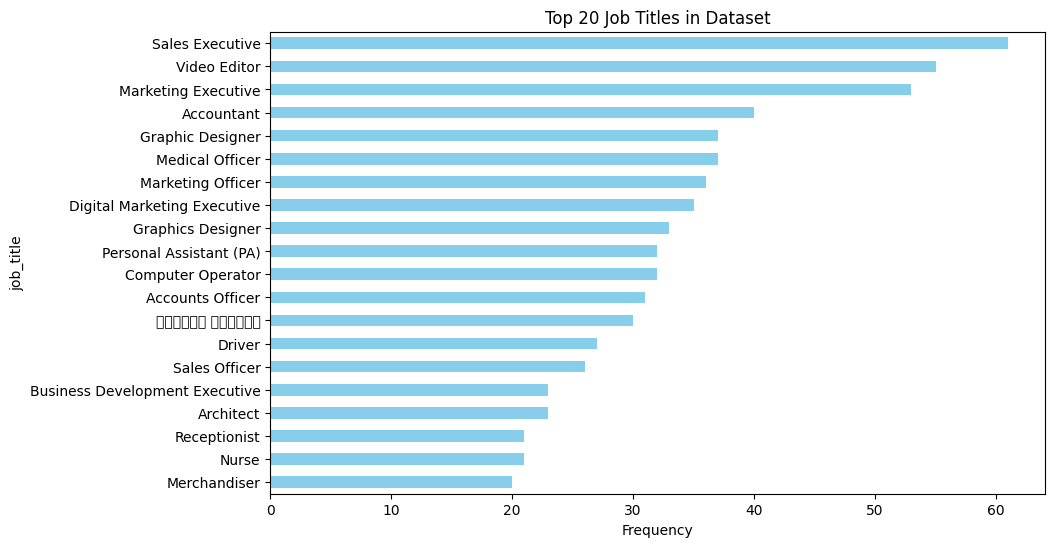

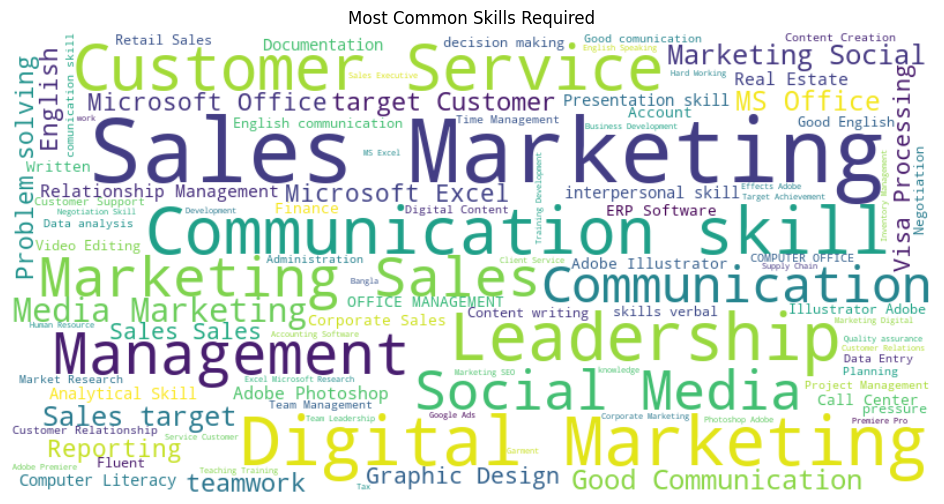

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# ১. Top 20 Job Titles Visualization
plt.figure(figsize=(10, 6))
# 'job_title' কলাম ব্যবহার করা হচ্ছে
df_final['job_title'].value_counts().head(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 Job Titles in Dataset')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()
plt.show()

# ২. Word Cloud for Skills
# আমরা 'skills' কলামটি ব্যবহার করছি (আগে নাম ছিল SkillsRequired)
# নাল ভ্যালু হ্যান্ডেল করার জন্য fillna('') ব্যবহার করা হয়েছে
skills_text = " ".join(df_final['skills'].fillna('').astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      colormap='viridis', max_words=100).generate(skills_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Skills Required')
plt.show()

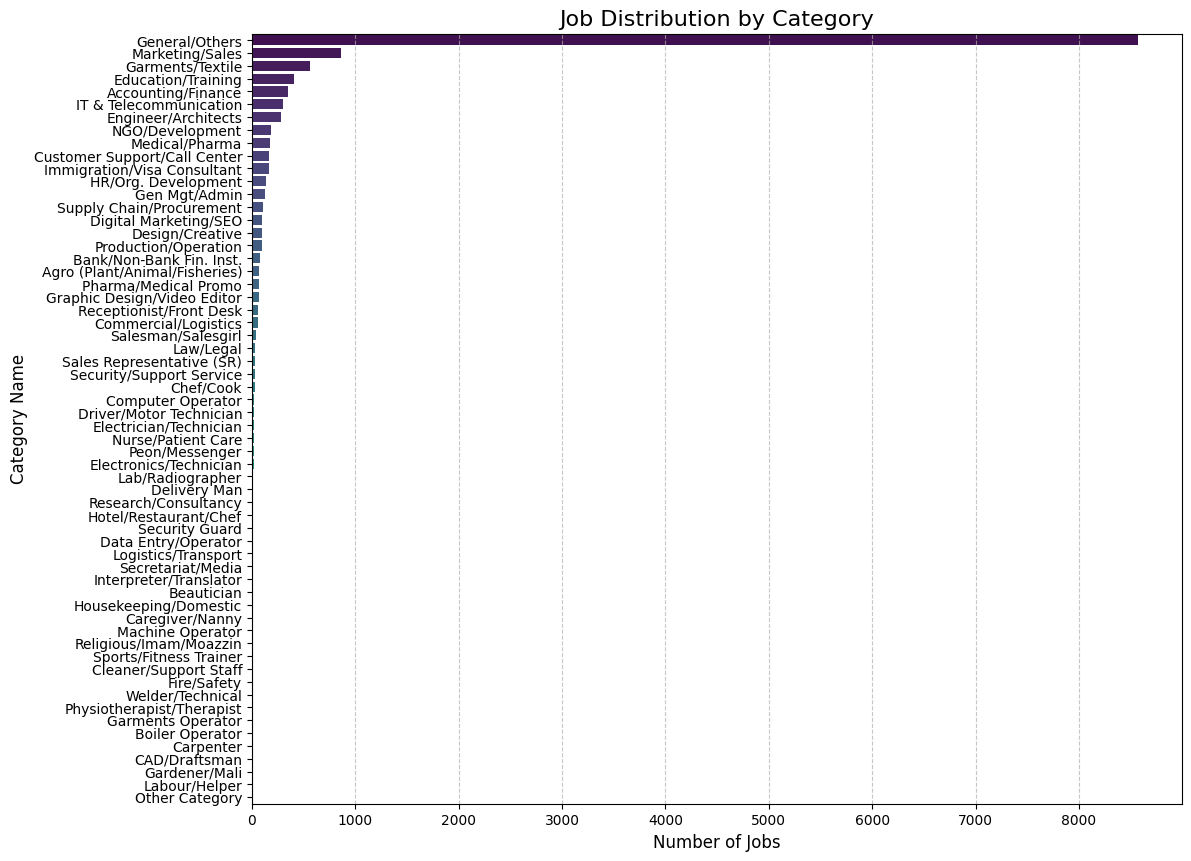

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# ১. ডিসপ্লে সাইজ সেট করা (গ্রাফ সুন্দর দেখার জন্য)
plt.figure(figsize=(12, 10))

# ২. ডেটা প্লট করা (Countplot)
# order=... দিয়ে আমরা বেশি থেকে কম অর্ডারে সাজিয়েছি
sns.countplot(
    data=df, 
    y='category_name', 
    order=df['category_name'].value_counts().index, 
    palette='viridis' # সুন্দর কালার প্যালেট
)

# ৩. টাইটেল এবং লেবেল দেওয়া
plt.title('Job Distribution by Category', fontsize=16)
plt.xlabel('Number of Jobs', fontsize=12)
plt.ylabel('Category Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7) # ব্যাকগ্রাউন্ডে গ্রিড লাইন

# ৪. গ্রাফ দেখানো
plt.show()

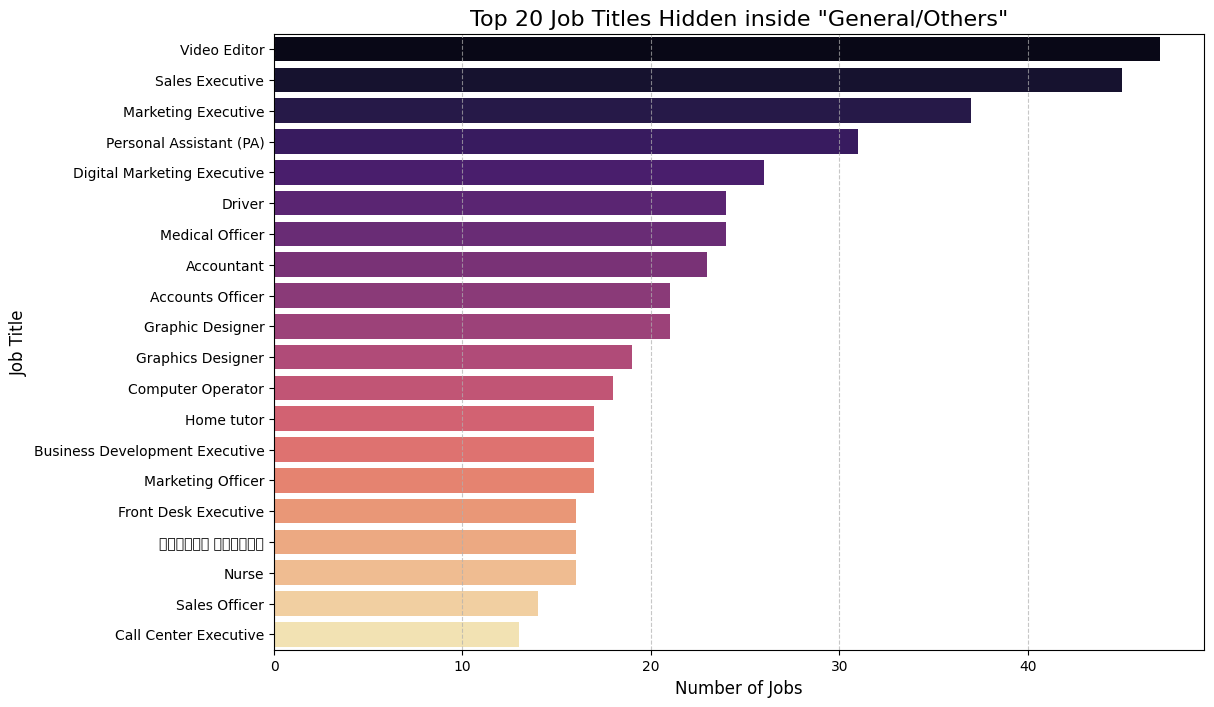

Top 5 Jobs inside General/Others:
job_title
Video Editor                      47
Sales Executive                   45
Marketing Executive               37
Personal Assistant (PA)           31
Digital Marketing Executive       26
Driver                            24
Medical Officer                   24
Accountant                        23
Accounts Officer                  21
Graphic Designer                  21
Graphics Designer                 19
Computer Operator                 18
Home tutor                        17
Business Development Executive    17
Marketing Officer                 17
Front Desk Executive              16
সহকারী শিক্ষক                     16
Nurse                             16
Sales Officer                     14
Call Center Executive             13
Name: count, dtype: int64


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# ১. শুধু 'General/Others' (ID 0) এর ডেটা ফিল্টার করা
# (Bangla Job গুলো বাদ দিয়েছি, যাতে রেজাল্ট ক্লিন আসে)
general_jobs = df[
    (df['category_id'].astype(str) == '0') & 
    (~df['job_title'].str.contains("Bangla Job", case=False, na=False))
]

# ২. টপ ২০টি জব টাইটেল বের করা
top_general_titles = general_jobs['job_title'].value_counts().head(20)

# ৩. গ্রাফ প্লট করা
plt.figure(figsize=(12, 8))
sns.barplot(x=top_general_titles.values, y=top_general_titles.index, palette='magma')

plt.title('Top 20 Job Titles Hidden inside "General/Others"', fontsize=16)
plt.xlabel('Number of Jobs', fontsize=12)
plt.ylabel('Job Title', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ৪. টেক্সট প্রিন্ট করা
print("Top 5 Jobs inside General/Others:")
print(top_general_titles.head(20))

In [48]:
import pandas as pd

# ==========================================
# 0. DISPLAY SETTINGS
# ==========================================
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', 1000)

print(f"⚠️ General/Others Jobs Before Fix: {len(df[df['category_id'].astype(str) == '0'])}")


# ==========================================
# 1. RE-CLASSIFY "GENERAL/OTHERS" (The Fix)
# ==========================================
# রুলস: কোন শব্দ পেলে কোন আইডিতে পাঠাবো
reclass_rules = {
    # --- Creative & Design (ID 18) ---
    'video': 18, 'editor': 18, 'graphic': 18, 'designer': 18, 'motion': 18, 'animator': 18, 'photographer': 18,
    
    # --- Marketing & Sales (ID 9 & 10) ---
    'sales': 9, 'marketing': 9, 'business development': 9, 'brand': 9, 'bde': 9,
    'digital marketing': 10, 'seo': 10, 'content writer': 10, 'social media': 10,
    
    # --- IT & Software (ID 8) ---
    'software': 8, 'developer': 8, 'engineer': 8, 'programmer': 8, 'web': 8, 'stack': 8, 'laravel': 8, 'react': 8, 'python': 8,
    
    # --- Accounts & Finance (ID 1) ---
    'account': 1, 'finance': 1, 'audit': 1, 'cashier': 1, 'billing': 1,
    
    # --- Admin & Management (ID 7 & 28) ---
    'manager': 7, 'admin': 7, 'executive': 7, 'officer': 7, 
    'secretary': 28, 'personal assistant': 28, 'pa': 28,
    
    # --- Education (ID 4) ---
    'teacher': 4, 'lecturer': 4, 'tutor': 4, 'trainer': 4, 'faculty': 4, 'professor': 4, 'শিক্ষক': 4,
    
    # --- Medical (ID 11 & 63) ---
    'medical': 11, 'doctor': 11, 'pharma': 11, 
    'nurse': 63, 'patient': 63, 'brother': 63,
    
    # --- Engineering (Civil/Mech/Elec) (ID 5 & 66) ---
    'civil': 5, 'architect': 5, 'mechanical': 5, 'electrical': 5, 'electrician': 66,
    
    # --- Blue Collar / Support ---
    'driver': 67, 'ড্রাইভার': 67,
    'security': 70, 'guard': 70,
    'cleaner': 80, 'housekeeper': 80,
    'cook': 68, 'chef': 68,
    'reception': 14, 'front desk': 14,
    'operator': 15, 'data entry': 15, 'computer operator': 15
}

def fix_general_category(row):
    # শুধু যদি Category 0 হয়, তখন চেক করবো
    if str(row['category_id']) in ['0', '0.0', 'nan']:
        title = str(row['job_title']).lower()
        # টাইটেল চেক করে সঠিক আইডি বসানো
        for keyword, new_id in reclass_rules.items():
            if keyword in title:
                return new_id
    return row['category_id']

# অ্যাপ্লাই করা
df['category_id'] = df.apply(fix_general_category, axis=1)

print(f"✅ General/Others Jobs After Fix: {len(df[df['category_id'].astype(str) == '0'])}")
print("(Many jobs have been moved to their correct categories!)")


# ==========================================
# 2. APPLY FIXED CATEGORY NAMES (Updated Map)
# ==========================================
# কমপ্লিট ম্যাপ (Fire/Safety সহ)
fixed_category_map = {
    '1': 'Accounting/Finance', '2': 'Bank/Non-Bank Fin.', '3': 'Supply Chain', '4': 'Education/Training', 
    '5': 'Engineer/Architects', '6': 'Garments/Textile', '7': 'Gen Mgt/Admin', '8': 'IT & Telecommunication', 
    '9': 'Marketing/Sales', '10': 'Digital Marketing/SEO', '11': 'Medical/Pharma', '12': 'NGO/Development', 
    '13': 'Research/Consultancy', '14': 'Receptionist', '15': 'Data Entry/Operator', '16': 'Call Center', 
    '17': 'HR/Org. Dev.', '18': 'Design/Creative', '19': 'Production/Operation', '20': 'Visa Consultant', 
    '22': 'Law/Legal', '24': 'Security Service', '26': 'Agro/Fisheries', '27': 'Logistics', 
    '28': 'Secretariat/Media', '29': 'Pharma Promo', '61': 'Computer Operator', '62': 'Electrician', 
    '63': 'Nurse', '64': 'Hotel/Restaurant', '65': 'Lab Tech', '66': 'Electronics', '67': 'Driver', 
    '68': 'Chef/Cook', '69': 'Housekeeping', '70': 'Security Guard', '71': 'Graphic/Video', 
    '72': 'Welder', '77': 'Delivery Man', '79': 'Peon', '80': 'Cleaner', '83': 'Salesman', 
    '84': 'Sales Rep (SR)', 
    '89': 'Fire/Safety',          # <--- Fixed & Included
    '0': 'General/Others'
}

df['category_name'] = df['category_id'].astype(str).map(fixed_category_map).fillna('Others')
print("✅ Category Names Applied (Includes 'Fire/Safety')")




⚠️ General/Others Jobs Before Fix: 8567
✅ General/Others Jobs After Fix: 1927
(Many jobs have been moved to their correct categories!)
✅ Category Names Applied (Includes 'Fire/Safety')


In [49]:
df_final.head(50)

,job_id,company_id,category_id,category_name,company_name,company_web,company_address,company_business,job_title,job_description,job_type,work_place,job_benefits,job_source,posted_on,deadline,vacancies,skills,suggested_skills,gender,apply_url,apply_email,apply_instruction,online_apply,min_salary,max_salary,district,fine_grained_location,education_level,education_subject,min_age,max_age,min_experience,max_experience
0,JOB-00001,COM-5000,8,IT & Telecommunication,RK Supply Ltd.,NaN,NaN,None,Data Analyst / Accounts Officer,"RK Supply Ltd. (Company No. 09740433), establi...",Full Time,Work at office,None,NaN,"Dec 6, 2025","Dec 31, 2025",6.0,"Accounting,Accounting Data Entry,Canva Pro,Dat...","Accounting Data Entry,Accounting Software,Acco...","M,F",NaN,NaN,Selected candidates for this role will be trai...,True,20000.0,35000.0,Dhaka,Banani,Bachelor,Computer Science,20.0,35.0,1.0,2.0
1,JOB-00002,COM-5001,8,IT & Telecommunication,Pridesys IT Limited,NaN,"Level-11, Vision 2021 Tower-1, Software Techno...",Pridesys IT Ltd. own developed ERP product for...,Processor/Senior Processor,Review property preservation work orders submi...,Full Time,Work at office,Salary Review: Yearly Festival Bonus: 2 Dinner...,NaN,"Dec 6, 2025","Jan 5, 2026",2.0,"Flexibility and Adaptability,Google Sheets,MS ...","Client Service,Property Management,Property Pr...",M,NaN,NaN,None,True,NaN,NaN,Dhaka,Kawran Bazar,Any,Any,20.0,35.0,2.0,NaN
2,JOB-00003,COM-5002,11,Medical/Pharma,Aalok Healthcare & Hospital,https://www.aalokhealthcare.com/,"Corporate Office: House# 3, Road # 4, Block # ...",None,Assistant Manager (Customer Care / Admin),Shift Management and Operational Leadership (2...,Full Time,Work at office,Provident fund Salary Review: Yearly Festival ...,NaN,"Dec 6, 2025","Dec 26, 2025",4.0,"Computer Literacy,Customer Service,Health/ Med...","Administration,Complaint Management,Hospital B...",M,NaN,Send your CV to the given email hr.aalok@gmail...,Read before Apply and email us mention as Expe...,True,NaN,NaN,Dhaka,Mirpur,Any,Any,NaN,NaN,3.0,5.0
3,JOB-00004,COM-5003,84,Sales Representative (SR),Eureka food and beverage,NaN,"Jong & sons market,Anwar jong road,Ashulia, Sa...","We manufacture, market, and sell all types of ...",Sales Representative (SR),দায়িত্ব ও কর্তব্য: কোম্পানির পণ্য বিক্রয় করা...,Full Time,NaN,অন্যান্য সুবিধা: আলোচনা সাপেক্ষে,NaN,"Dec 6, 2025","Jan 5, 2026",NaN,None,"Market Research,Marketing,Sales & Marketing,Sa...",M,NaN,NaN,আগ্রহী প্রার্থীদের আবেদন করার জন্য উৎসাহিত করা...,True,18000.0,22000.0,Anywhere in Bangladesh,none,Any,Any,22.0,40.0,2.0,5.0
4,JOB-00005,COM-5004,9,Marketing/Sales,Rancon Holdings Limited,NaN,"117/A Old Airport Road, Bijoy Sharani","A local conglomerate, doing diversified busine...",Sales Hero (Sales Executive - Freshers) RANGS ...,Greet and assist walk-in customers with a frie...,Full Time,Work at office,"T/A,Mobile bill,Performance bonus Salary Revie...",NaN,"Dec 6, 2025","Dec 31, 2025",20.0,None,"Marketing and Sales,Retail Sales,Sales,Sales &...",M,NaN,NaN,None,True,20000.0,20000.0,Anywhere in Bangladesh,none,Any,Any,24.0,30.0,NaN,NaN
5,JOB-00006,COM-5005,17,HR/Org. Development,ALTERNATIVE RECRUITMENT LTD.,NaN,"BNS Center, Level 08\r\nSector 07\r\nUttara ,D...",Alternative Recruitment is a certified Educati...,HR Manager - Female,Join Our Global Team – Female HR Manager Wante...,Full Time,"Work from home,Work at office","Profit share,Mobile bill Salary Review: Yearly...",NaN,"Dec 6, 2025","Jan 5, 2026",15.0,"Computer Literacy,English typing,FLUENCY IN EN...","Human Resource Management,Management,Recruitme...",F,NaN,Send your CV to the given email hiring@thealte...,Please read carefully : This position is open ...,True,20000.0,30000.0,Dhaka,"Uttara Sector 10, Uttara Sector 12",Diploma,Engineering,25.0,38.0,1.0,5.0
6,JOB-00007,COM-5006,6,Garments/Textile,Epyllion Group,NaN,"Corporate Office: NINAKABBO, Level: 12, 227/A,...","Textile, Garments, Garments Accessories, Washi...","Senior Executive - Dyeing (Textile Divisi

In [50]:
import pandas as pd

# ১. প্রতিটি কলামে মোট কয়টি ইউনিক ভ্যালু আছে তার সামারি
print("--- Number of Unique Values per Column ---")
print(df_final.nunique())
print("\n" + "="*50 + "\n")

# ২. যেসব কলামে ইউনিক ভ্যালু কম (যেমন ৫০টির নিচে), সেগুলোর ভ্যালুগুলো দেখা
# এটি করলে আপনি ডিস্ট্রিক্ট, জেন্ডার বা জব টাইপ-এর ভ্যালুগুলো সরাসরি দেখতে পাবেন
print("--- Actual Unique Values (for categorical columns) ---")

for col in df_final.columns:
    unique_count = df_final[col].nunique()
    
    # আমরা শুধুমাত্র ৫০টির কম ইউনিক ভ্যালু আছে এমন কলামগুলো প্রিন্ট করছি
    # যাতে ডেসক্রিপশন বা আইডি কলামগুলো প্রিন্ট না হয়
    if unique_count < 50:
        unique_vals = df_final[col].dropna().unique() # NaN বাদ দিয়ে ইউনিক ভ্যালু
        print(f"\n{col} ({unique_count} unique values):")
        print(unique_vals)
    else:
        print(f"\n{col}: Too many unique values ({unique_count}) to display.")

# ৩. নির্দিষ্ট কোনো কলামের সব ভ্যালু দেখতে চাইলে (যেমন: district)
# print(df_final['district'].unique())

--- Number of Unique Values per Column ---
job_id                   13522
company_id                6125
category_id                 60
category_name               60
company_name              6125
company_web               1282
company_address           4704
company_business          2673
job_title                10398
job_description          12372
job_type                    10
work_place                   3
job_benefits              6334
job_source                  15
posted_on                  183
deadline                   230
vacancies                   71
skills                    5958
suggested_skills          8631
gender                       5
apply_url                  212
apply_email               1443
apply_instruction         2409
online_apply                 2
min_salary                 253
max_salary                 329
district                   448
fine_grained_location      648
education_level              3
education_subject            4
min_age                    

In [51]:
df_final.head(5)

,job_id,company_id,category_id,category_name,company_name,company_web,company_address,company_business,job_title,job_description,job_type,work_place,job_benefits,job_source,posted_on,deadline,vacancies,skills,suggested_skills,gender,apply_url,apply_email,apply_instruction,online_apply,min_salary,max_salary,district,fine_grained_location,education_level,education_subject,min_age,max_age,min_experience,max_experience
0,JOB-00001,COM-5000,8,IT & Telecommunication,RK Supply Ltd.,NaN,NaN,None,Data Analyst / Accounts Officer,"RK Supply Ltd. (Company No. 09740433), establi...",Full Time,Work at office,None,NaN,"Dec 6, 2025","Dec 31, 2025",6.0,"Accounting,Accounting Data Entry,Canva Pro,Dat...","Accounting Data Entry,Accounting Software,Acco...","M,F",NaN,NaN,Selected candidates for this role will be trai...,True,20000.0,35000.0,Dhaka,Banani,Bachelor,Computer Science,20.0,35.0,1.0,2.0
1,JOB-00002,COM-5001,8,IT & Telecommunication,Pridesys IT Limited,NaN,"Level-11, Vision 2021 Tower-1, Software Techno...",Pridesys IT Ltd. own developed ERP product for...,Processor/Senior Processor,Review property preservation work orders submi...,Full Time,Work at office,Salary Review: Yearly Festival Bonus: 2 Dinner...,NaN,"Dec 6, 2025","Jan 5, 2026",2.0,"Flexibility and Adaptability,Google Sheets,MS ...","Client Service,Property Management,Property Pr...",M,NaN,NaN,None,True,NaN,NaN,Dhaka,Kawran Bazar,Any,Any,20.0,35.0,2.0,NaN
2,JOB-00003,COM-5002,11,Medical/Pharma,Aalok Healthcare & Hospital,https://www.aalokhealthcare.com/,"Corporate Office: House# 3, Road # 4, Block # ...",None,Assistant Manager (Customer Care / Admin),Shift Management and Operational Leadership (2...,Full Time,Work at office,Provident fund Salary Review: Yearly Festival ...,NaN,"Dec 6, 2025","Dec 26, 2025",4.0,"Computer Literacy,Customer Service,Health/ Med...","Administration,Complaint Management,Hospital B...",M,NaN,Send your CV to the given email hr.aalok@gmail...,Read before Apply and email us mention as Expe...,True,NaN,NaN,Dhaka,Mirpur,Any,Any,NaN,NaN,3.0,5.0
3,JOB-00004,COM-5003,84,Sales Representative (SR),Eureka food and beverage,NaN,"Jong & sons market,Anwar jong road,Ashulia, Sa...","We manufacture, market, and sell all types of ...",Sales Representative (SR),দায়িত্ব ও কর্তব্য: কোম্পানির পণ্য বিক্রয় করা...,Full Time,NaN,অন্যান্য সুবিধা: আলোচনা সাপেক্ষে,NaN,"Dec 6, 2025","Jan 5, 2026",NaN,None,"Market Research,Marketing,Sales & Marketing,Sa...",M,NaN,NaN,আগ্রহী প্রার্থীদের আবেদন করার জন্য উৎসাহিত করা...,True,18000.0,22000.0,Anywhere in Bangladesh,none,Any,Any,22.0,40.0,2.0,5.0
4,JOB-00005,COM-5004,9,Marketing/Sales,Rancon Holdings Limited,NaN,"117/A Old Airport Road, Bijoy Sharani","A local conglomerate, doing diversified busine...",Sales Hero (Sales Executive - Freshers) RANGS ...,Greet and assist walk-in customers with a frie...,Full Time,Work at office,"T/A,Mobile bill,Performance bonus Salary Revie...",NaN,"Dec 6, 2025","Dec 31, 2025",20.0,None,"Marketing and Sales,Retail Sales,Sales,Sales &...",M,NaN,NaN,None,True,20000.0,20000.0,Anywhere in Bangladesh,none,Any,Any,24.0,30.0,NaN,NaN


new

In [48]:
# ডেটা ফিল্টার (স্যালারি এবং জেন্ডার যেখানে আছে)
df_viz = df_final[(df_final['min_salary'] > 0) & (df_final['gender'].isin(['Male', 'Female', 'Both']))]

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_viz, x='gender', y='min_salary', hue='gender', 
               palette='muted', split=False, inner="quart")

plt.title('Salary Distribution by Gender', fontsize=16)
plt.ylim(0, 150000) # স্যালারি রেঞ্জ ঠিক রাখা
plt.grid(axis='y', alpha=0.3)
plt.show()

KeyError: 'gender'

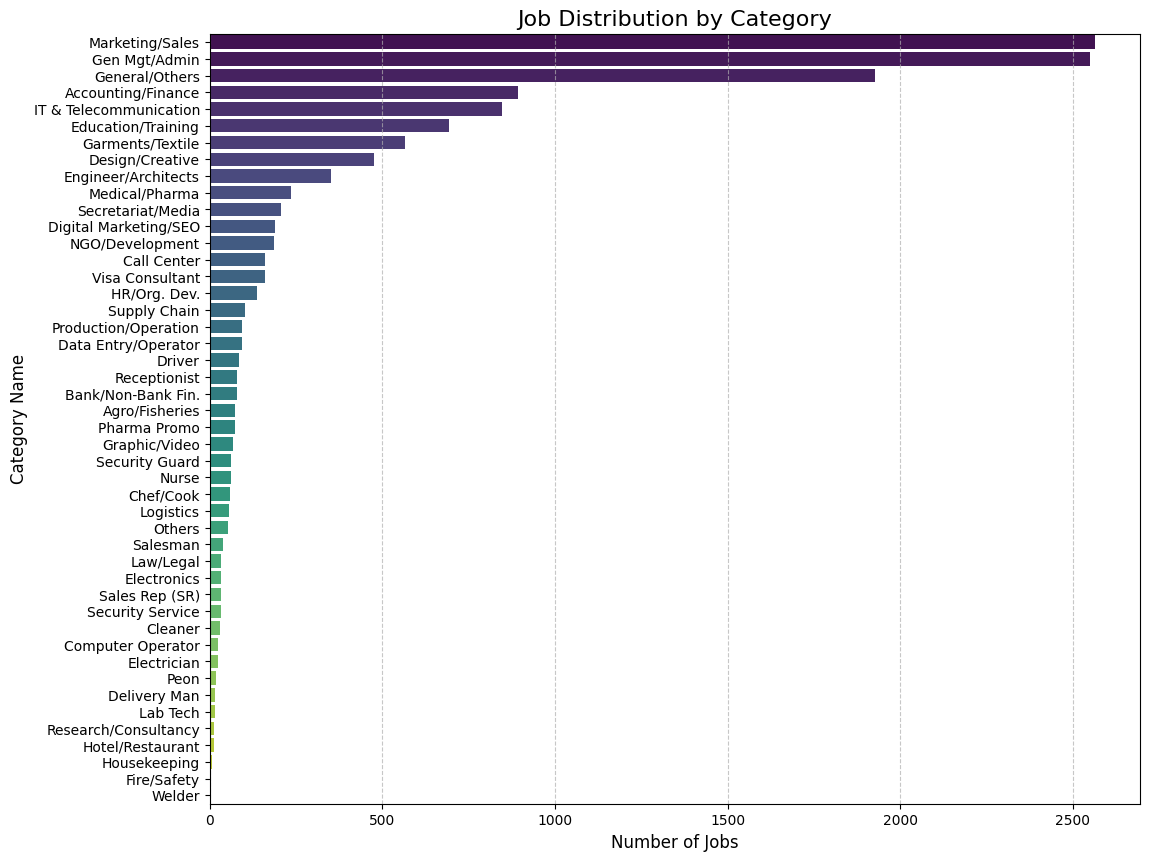

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# ১. ডিসপ্লে সাইজ সেট করা (গ্রাফ সুন্দর দেখার জন্য)
plt.figure(figsize=(12, 10))

# ২. ডেটা প্লট করা (Countplot)
# order=... দিয়ে আমরা বেশি থেকে কম অর্ডারে সাজিয়েছি
sns.countplot(
    data=df, 
    y='category_name', 
    order=df['category_name'].value_counts().index, 
    palette='viridis' # সুন্দর কালার প্যালেট
)

# ৩. টাইটেল এবং লেবেল দেওয়া
plt.title('Job Distribution by Category', fontsize=16)
plt.xlabel('Number of Jobs', fontsize=12)
plt.ylabel('Category Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7) # ব্যাকগ্রাউন্ডে গ্রিড লাইন

# ৪. গ্রাফ দেখানো
plt.show()

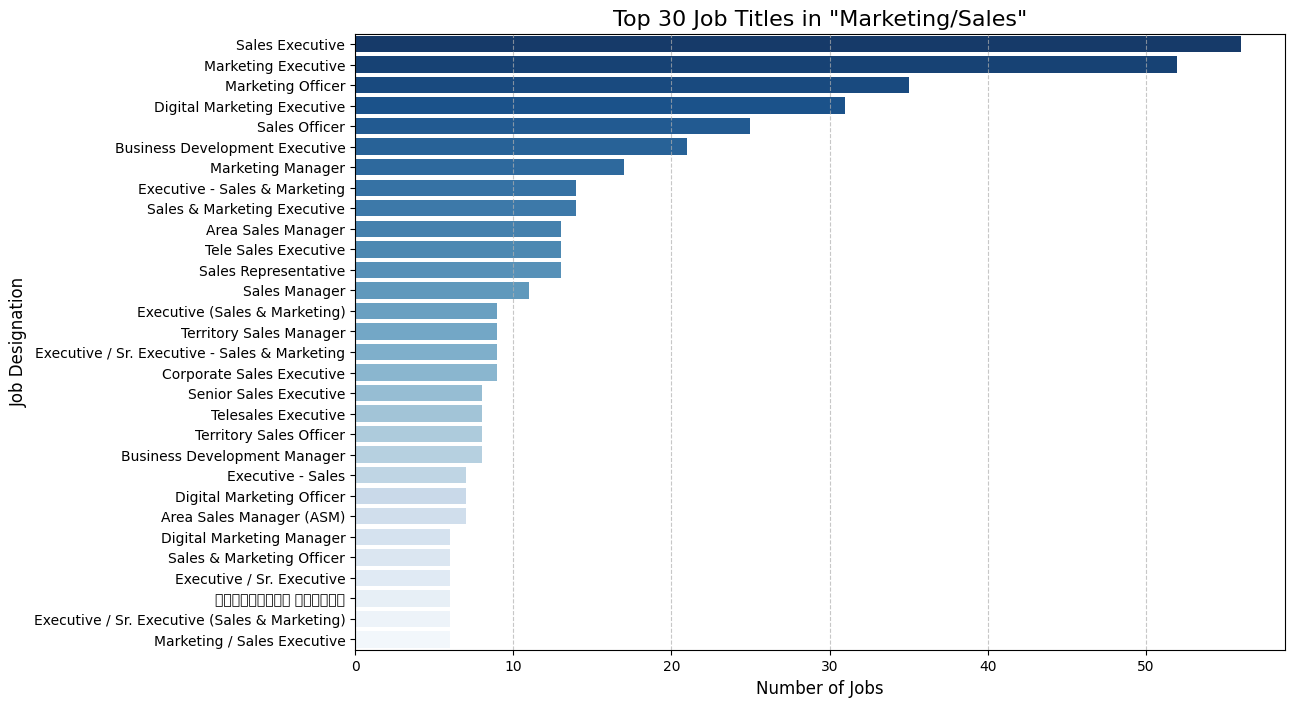

Total Jobs found in Marketing/Sales: 2565

Top 5 Most Demandable Roles:
job_title
Sales Executive                                  56
Marketing Executive                              52
Marketing Officer                                35
Digital Marketing Executive                      31
Sales Officer                                    25
Business Development Executive                   21
Marketing Manager                                17
Executive - Sales & Marketing                    14
Sales & Marketing Executive                      14
Area Sales Manager                               13
Tele Sales Executive                             13
Sales Representative                             13
Sales Manager                                    11
Executive (Sales & Marketing)                     9
Territory Sales Manager                           9
Executive / Sr. Executive - Sales & Marketing     9
Corporate Sales Executive                         9
Senior Sales Executive            

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# ১. ফিল্টার করা: শুধু 'Marketing/Sales' ক্যাটাগরির জব নেওয়া
# (General থেকে ফিক্স হয়ে আসা জবগুলোও এখন এর মধ্যে আছে)
marketing_jobs = df_final[df_final['category_name'] == 'Marketing/Sales']

# ২. টপ ২০টি পদের নাম বের করা
top_marketing_titles = marketing_jobs['job_title'].value_counts().head(30)

# ৩. গ্রাফ প্লট করা
plt.figure(figsize=(12, 8))
sns.barplot(x=top_marketing_titles.values, y=top_marketing_titles.index, palette='Blues_r')

plt.title('Top 30 Job Titles in "Marketing/Sales"', fontsize=16)
plt.xlabel('Number of Jobs', fontsize=12)
plt.ylabel('Job Designation', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ৪. বিস্তারিত প্রিন্ট করা
print(f"Total Jobs found in Marketing/Sales: {len(marketing_jobs)}")
print("\nTop 5 Most Demandable Roles:")
print(top_marketing_titles.head(30))

In [21]:
df_final.head(5)

,job_id,company_id,category_id,category_name,job_title,company_name,job_description,job_type,posted_on,deadline,vacancies,skills,district,min_salary,max_salary
0,JOB-00001,COM-5000,8,IT & Telecommunication,Data Analyst / Accounts Officer,RK Supply Ltd.,"RK Supply Ltd. (Company No. 09740433), establi...",Full Time,"Dec 6, 2025","Dec 31, 2025",6.0,"Accounting,Accounting Data Entry,Canva Pro,Dat...",Dhaka,20000.0,35000.0
1,JOB-00002,COM-5001,8,IT & Telecommunication,Processor/Senior Processor,Pridesys IT Limited,Review property preservation work orders submi...,Full Time,"Dec 6, 2025","Jan 5, 2026",2.0,"Flexibility and Adaptability,Google Sheets,MS ...",Dhaka,NaN,NaN
2,JOB-00003,COM-5002,11,Medical/Pharma,Assistant Manager (Customer Care / Admin),Aalok Healthcare & Hospital,Shift Management and Operational Leadership (2...,Full Time,"Dec 6, 2025","Dec 26, 2025",4.0,"Computer Literacy,Customer Service,Health/ Med...",Dhaka,NaN,NaN
3,JOB-00004,COM-5003,84,Sales Rep (SR),Sales Representative (SR),Eureka food and beverage,দায়িত্ব ও কর্তব্য: কোম্পানির পণ্য বিক্রয় করা...,Full Time,"Dec 6, 2025","Jan 5, 2026",NaN,None,Anywhere in Bangladesh,18000.0,22000.0
4,JOB-00005,COM-5004,9,Marketing/Sales,Sales Hero (Sales Executive - Freshers) RANGS ...,Rancon Holdings Limited,Greet and assist walk-in customers with a frie...,Full Time,"Dec 6, 2025","Dec 31, 2025",20.0,None,Anywhere in Bangladesh,20000.0,20000.0


# **Filter Distribution**

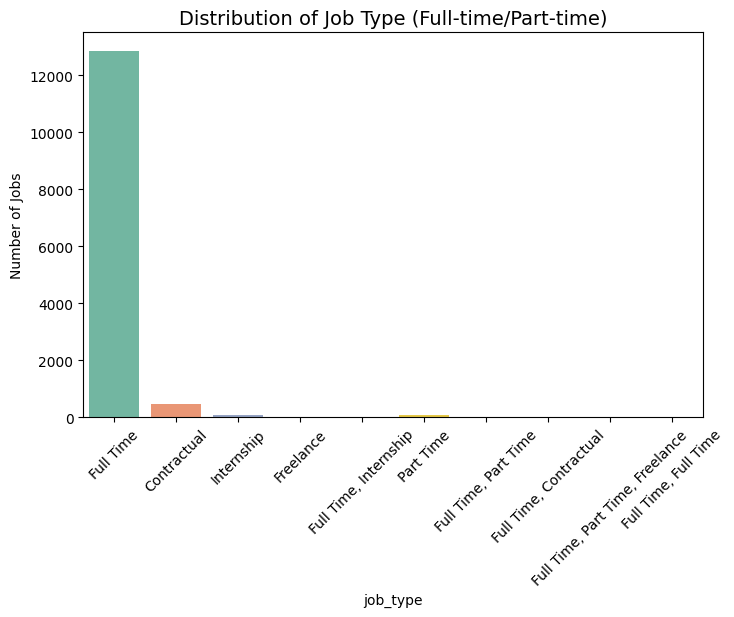

Salary Disclosure Rate:
has_salary
Hidden/Negotiable    72.474486
Disclosed            27.525514
Name: proportion, dtype: float64


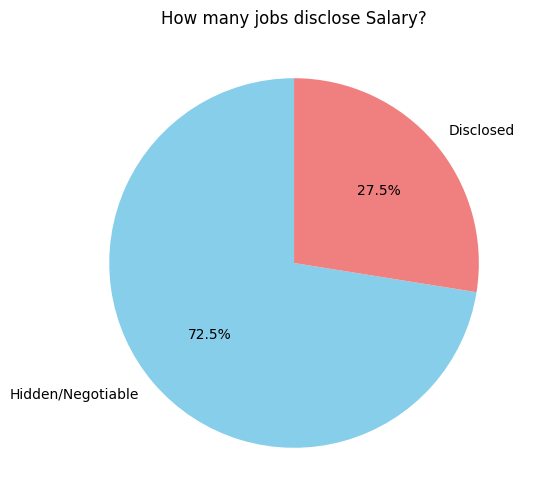

In [25]:

# -৩. Analyze Job Nature (Job Type) ---
plt.figure(figsize=(8, 5))
# Tomar notun list onushare x axis hobe 'job_type'
sns.countplot(data=df_final, x='job_type', palette='Set2') 
plt.title('Distribution of Job Type (Full-time/Part-time)', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Number of Jobs')
plt.show()

# --- ৪. Analyze Salary Presence ---
# Notun list onushare 'JobSalaryMaxSalary' hoyeche 'max_salary'
# Bot-er jonno janata dorkar koyti job-e salary mention kora ache

# min_salary ba max_salary jekono ekta check korlei hobe
df_final['has_salary'] = df_final['max_salary'].apply(
    lambda x: 'Disclosed' if pd.notnull(x) and x > 0 else 'Hidden/Negotiable'
)

print("Salary Disclosure Rate:")
print(df_final['has_salary'].value_counts(normalize=True) * 100)

# --- ৫. Salary Disclosure Visualization (Pie Chart) ---
plt.figure(figsize=(6, 6))
df_final['has_salary'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], startangle=90)
plt.title('How many jobs disclose Salary?')
plt.ylabel('') # Remove y-label for better look
plt.show()

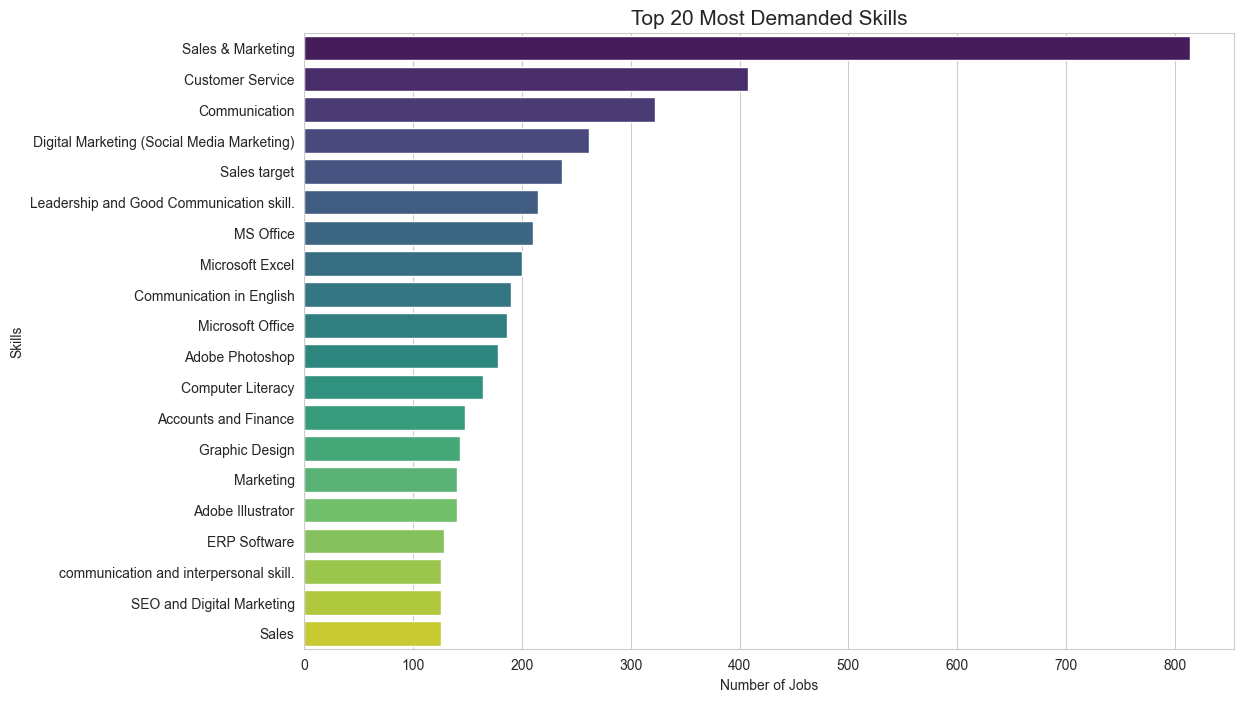

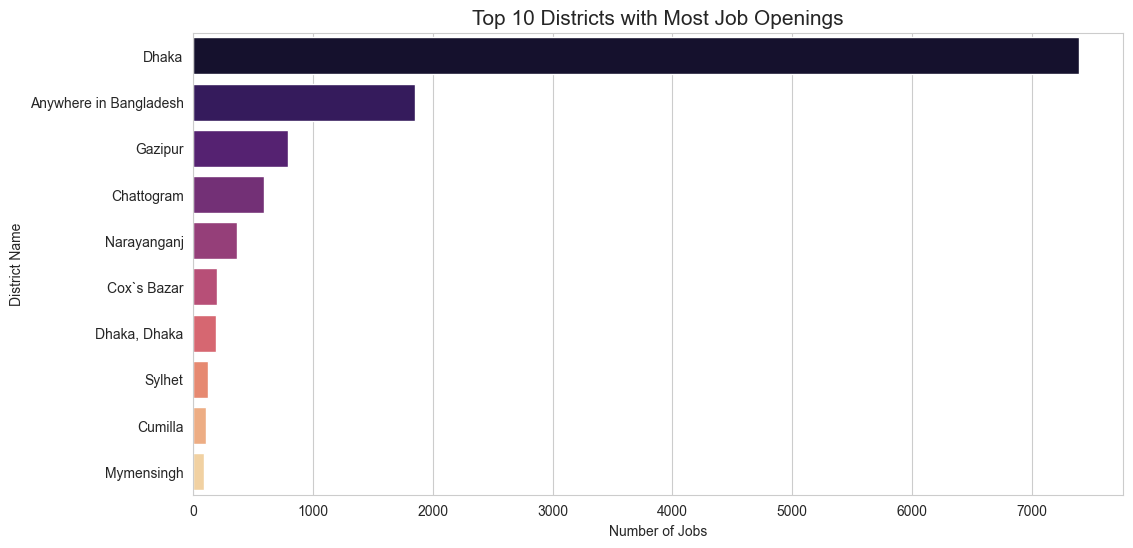

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# ---------------------------------------------------------
# 2. Top 20 In-Demand Skills (Bar Chart)
# ---------------------------------------------------------
# Purpose: Recommendation engine-er keyword matching-er jonno most important

# Extracting all skills from the 'skills' column
all_skills = []
df_final['skills'].dropna().astype(str).apply(lambda x: all_skills.extend([s.strip() for s in x.split(',')]))

# Counting most common skills
skill_counts = Counter(all_skills)
common_skills_df = pd.DataFrame(skill_counts.most_common(20), columns=['Skill', 'Count'])

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(y='Skill', x='Count', data=common_skills_df, palette='viridis')
plt.title('Top 20 Most Demanded Skills', fontsize=15)
plt.xlabel('Number of Jobs')
plt.ylabel('Skills')
plt.show()

# ---------------------------------------------------------
# 3. Top Hiring Districts (Bar Chart)
# ---------------------------------------------------------
# Purpose: User-ke location suggestion dewar jonno

plt.figure(figsize=(12, 6))
top_districts = df_final['district'].value_counts().head(10)

sns.barplot(x=top_districts.values, y=top_districts.index, palette='magma')

plt.title('Top 10 Districts with Most Job Openings', fontsize=15)
plt.xlabel('Number of Jobs')
plt.ylabel('District Name')
plt.show()


# **Salary Distribution**

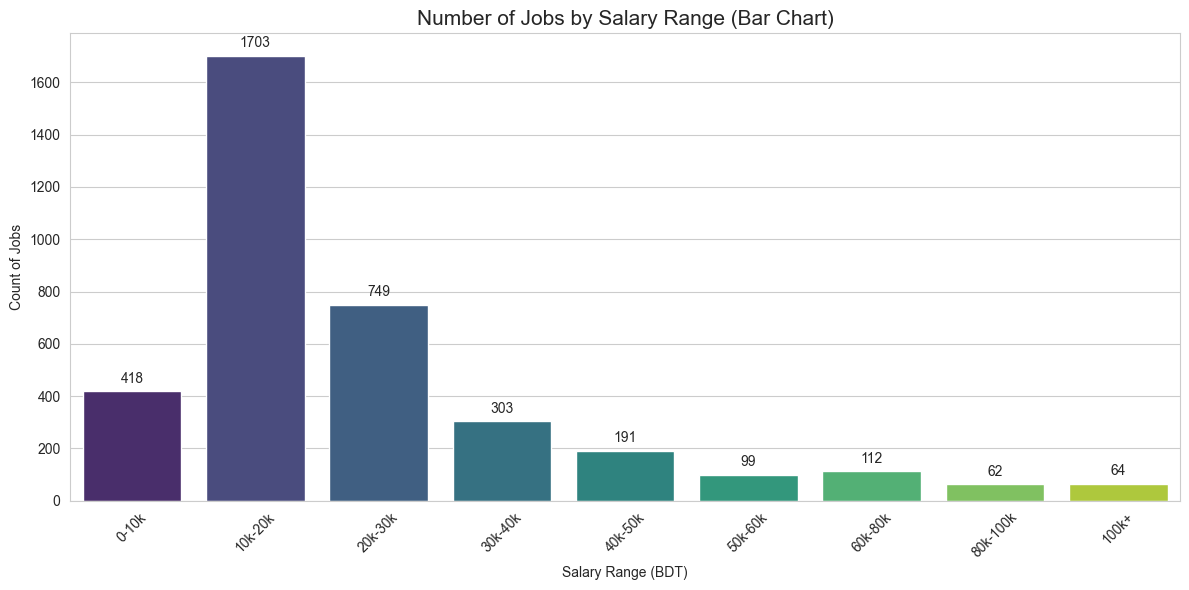

In [ ]:


# ১. স্যালারি রেঞ্জ বা বিনস (Bins) তৈরি করা
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 80000, 100000, 200000]
labels = ['0-10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '50k-60k', '60k-80k', '80k-100k', '100k+']

# ২. ডেটা ফিল্টার এবং বিন করা
# শুধুমাত্র ০ এর চেয়ে বড় স্যালারি নেওয়া হচ্ছে
df_filtered = df_final[df_final['min_salary'] > 0].copy()
df_filtered['salary_range'] = pd.cut(df_filtered['min_salary'], bins=bins, labels=labels)

# ৩. বার প্লট তৈরি করা
plt.figure(figsize=(12, 6))
sns.countplot(data=df_filtered, x='salary_range', palette='viridis')

# ৪. গ্রাফের লেবেল এবং টাইটেল
plt.title('Number of Jobs by Salary Range (Bar Chart)', fontsize=15)
plt.xlabel('Salary Range (BDT)')
plt.ylabel('Count of Jobs')
plt.xticks(rotation=45)

# ৫. বার এর উপরে সংখ্যা (Count) দেখানো
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.tight_layout()
plt.savefig('salary_bar_plot.png')
plt.show()

# **Top 20 Job Locations**

In [ ]:
unique_locations = df['JobLocation'].unique()
print(unique_locations)
print(df['JobLocation'].nunique())

['Dhaka (Banani)' 'Dhaka (Kawran Bazar)' 'Dhaka (Mirpur)' ...
 'Brahmanbaria, Chattogram (Chattogram Sadar), Cox`s Bazar, Cumilla, Sylhet'
 'Dhaka (Agargaon, Banani, Cantonment, Dhanmondi, Kawran Bazar, Khilkhet, Mirpur, Mohakhali, Mohammadpur, Pallabi, Uttara)'
 'Rajshahi (Rajshahi Sadar), Rangpur (Rangpur Sadar)']
1094


In [28]:
plt.figure(figsize=(12, 6))
df_final['JobLocation'].value_counts().head(20).plot(kind='barh', color='teal')
plt.title('Top 20 Job Locations')
plt.xlabel('Number of Jobs')
plt.ylabel('Location')
plt.gca().invert_yaxis()
plt.savefig('top_locations.png')

KeyError: 'JobLocation'

<Figure size 1200x600 with 0 Axes>

# **Experiment Requirement Plot**

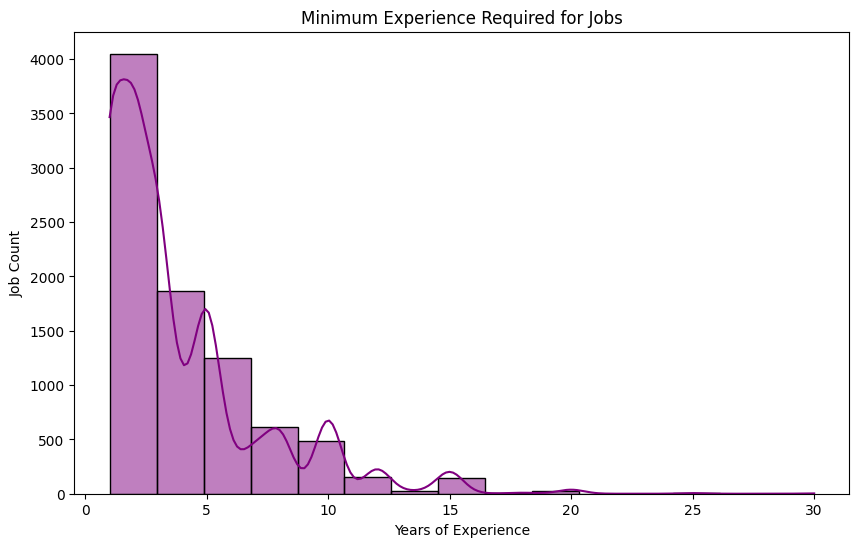

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['MinExperience'].dropna(), bins=15, color='purple', kde=True)
plt.title('Minimum Experience Required for Jobs')
plt.xlabel('Years of Experience')
plt.ylabel('Job Count')
plt.savefig('experience_distribution.png')

C:\Users\User\AppData\Local\Temp\ipykernel_2936\4050401057.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loc_salary_stats.values, y=loc_salary_stats.index, palette='magma')


Plot saved as 'salary_by_location.png'


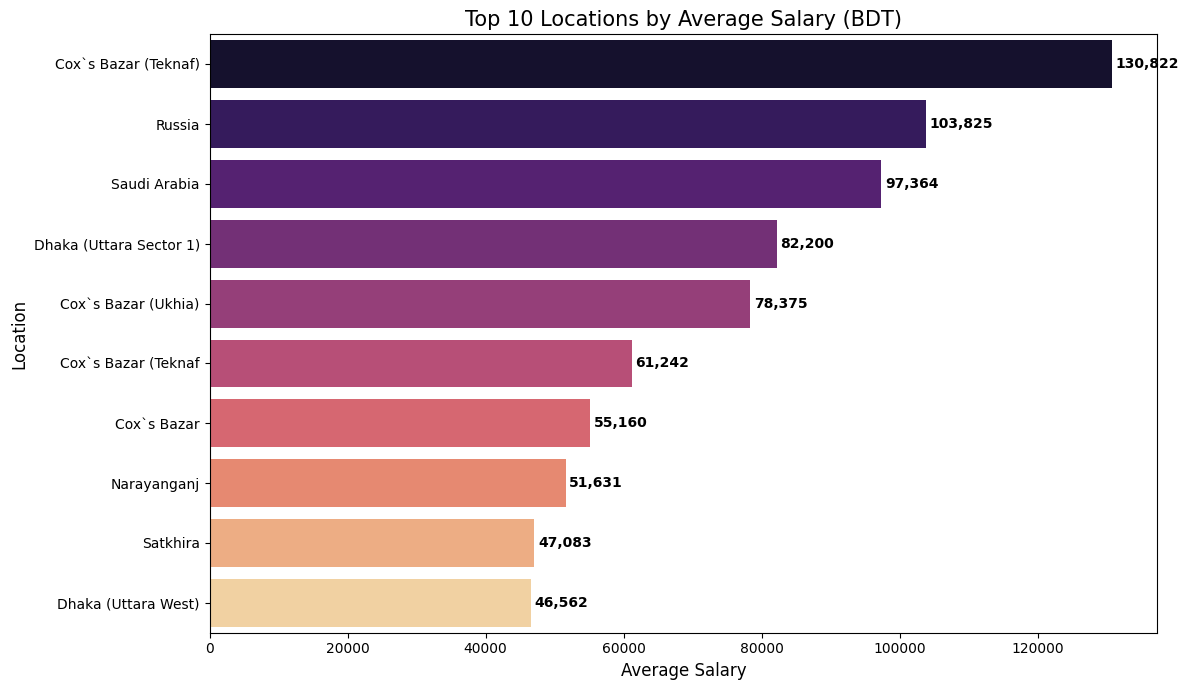

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ১. স্যালারি এবং লোকেশন ডেটা প্রসেসিং
# ---------------------------------------------------------

# Average Salary বের করা (যেখানে স্যালারি ডেটা আছে)
df_final['AvgSalary'] = (df_final['JobSalaryMinSalary'] + df_final['JobSalaryMaxSalary']) / 2

# লোকেশন ডেটা ক্লিন করা (অতিরিক্ত স্পেস বা কমা থাকলে ঠিক করা)
df_final['CleanLocation'] = df_final['JobLocation'].str.split(',').str[0].str.strip()

# যে ডেটাতে স্যালারি এবং লোকেশন দুইটাই আছে সেগুলো ফিল্টার করা
salary_loc_df = df_final.dropna(subset=['AvgSalary', 'CleanLocation'])

# ২. টপ ১০ লোকেশনের গড় স্যালারি বের করা
# ---------------------------------------------------------
# শুধু সেই লোকেশনগুলো নেওয়া যেখানে অন্তত ৫টি জব আছে (যাতে রেজাল্ট বিশ্বাসযোগ্য হয়)
loc_counts = salary_loc_df['CleanLocation'].value_counts()
top_locations = loc_counts[loc_counts >= 5].index

filtered_salary_df = salary_loc_df[salary_loc_df['CleanLocation'].isin(top_locations)]

# লোকেশন অনুযায়ী গড় স্যালারি ক্যালকুলেট করা
loc_salary_stats = filtered_salary_df.groupby('CleanLocation')['AvgSalary'].mean().sort_values(ascending=False).head(10)

# visualization
plt.figure(figsize=(12, 7))
sns.barplot(x=loc_salary_stats.values, y=loc_salary_stats.index, palette='magma')

plt.title('Top 10 Locations by Average Salary (BDT)', fontsize=15)
plt.xlabel('Average Salary', fontsize=12)
plt.ylabel('Location', fontsize=12)

# writing salaries values in graph
for i, v in enumerate(loc_salary_stats.values):
    plt.text(v + 500, i, f'{int(v):,}', color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('salary_by_location.png')
print("Plot saved as 'salary_by_location.png'")

# **Gender Distribution**

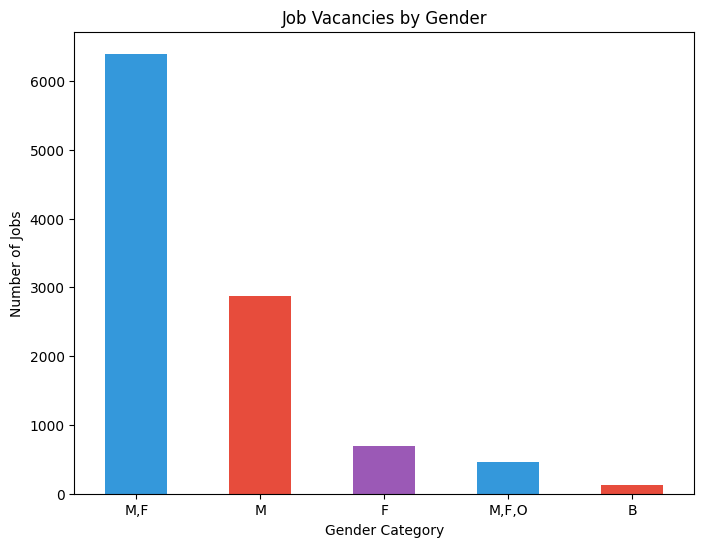

In [ ]:
plt.figure(figsize=(8, 6))
df_final['Gender'].value_counts().plot(kind='bar', color=['#3498db', '#e74c3c', '#9b59b6'])
plt.title('Job Vacancies by Gender')
plt.xlabel('Gender Category')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=0)
plt.savefig('gender_distribution.png')

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10542 entries, 0 to 10541
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CompanyName            10542 non-null  object        
 1   JobTitle               10542 non-null  object        
 2   JobDescription         10150 non-null  object        
 3   SkillsRequired         5194 non-null   object        
 4   SuggestedSkills        8272 non-null   object        
 5   MinExperience          8623 non-null   float64       
 6   MaxExperience          4688 non-null   float64       
 7   JobLocation            10542 non-null  object        
 8   JobNature              10542 non-null  object        
 9   JobSalaryMinSalary     2895 non-null   float64       
 10  JobSalaryMaxSalary     2896 non-null   float64       
 11  PostedOn               10542 non-null  object        
 12  Deadline               5176 non-null   datetime64[ns]
 13  E

# **Workplace Analysis**

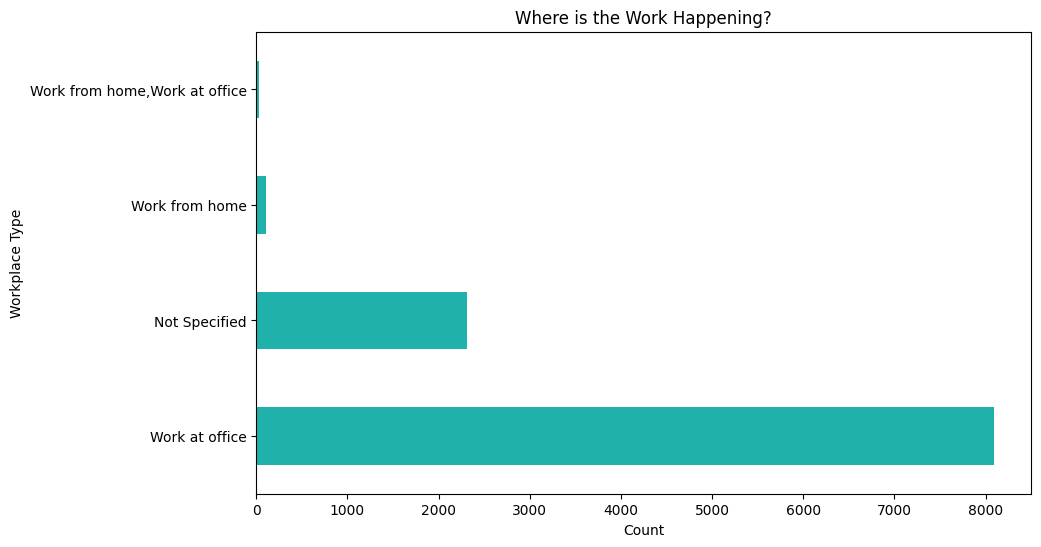

In [ ]:
plt.figure(figsize=(10, 6))
df_final['JobWorkPlace'].fillna('Not Specified').value_counts().head(5).plot(kind='barh', color='lightseagreen')
plt.title('Where is the Work Happening?')
plt.xlabel('Count')
plt.ylabel('Workplace Type')
plt.savefig('workplace_type.png')

# **Top 10 Educational Requirements**

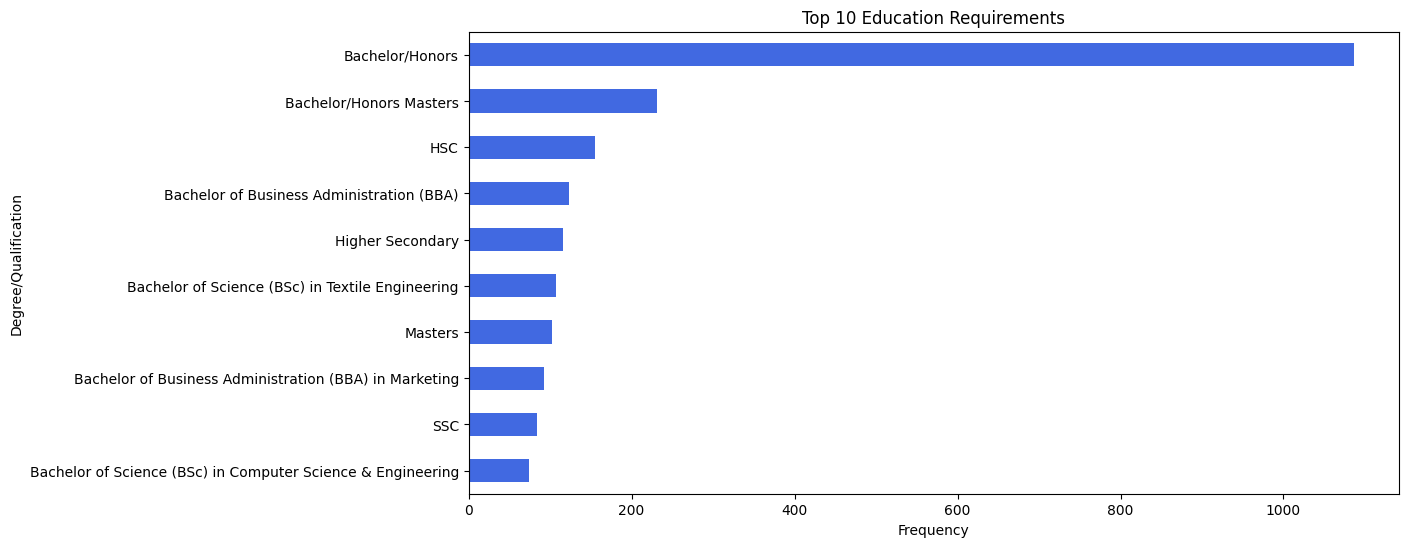

In [ ]:
plt.figure(figsize=(12, 6))
df_final['EducationRequirements'].value_counts().head(10).plot(kind='barh', color='royalblue')
plt.title('Top 10 Education Requirements')
plt.xlabel('Frequency')
plt.ylabel('Degree/Qualification')
plt.gca().invert_yaxis()
plt.savefig('education_requirements.png')